In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [3]:
filenames=os.listdir("../documents/input/train")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [7]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [8]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "../documents/input/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../documents/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1333/1333 [==============================] - 726s 544ms/step - loss: 0.7432 - accuracy: 0.6379 - val_loss: 0.7312 - val_accuracy: 0.6513
Epoch 2/10
1333/1333 [==============================] - 714s 536ms/step - loss: 0.5537 - accuracy: 0.7230 - val_loss: 0.4844 - val_accuracy: 0.7626
Epoch 3/10
1333/1333 [==============================] - 8842s 7s/step - loss: 0.5155 - accuracy: 0.7509 - val_loss: 0.4928 - val_accuracy: 0.7654
Epoch 4/10
1333/1333 [==============================] - 719s 539ms/step - loss: 0.4711 - accuracy: 0.7790 - val_loss: 0.4473 - val_accuracy: 0.7932
Epoch 5/10
1333/1333 [==============================] - 716s 537ms/step - loss: 0.4458 - accuracy: 0.7980 - val_loss: 0.4869 - val_accuracy: 0.7618
Epoch 6/10
1333/1333 [==============================] - 719s 539ms/step - loss: 0.4199 - accuracy: 0.8104 - val_loss: 0.3296 - val_accuracy: 0.8525
Epoch 7/10
1333/1333 [================

In [10]:
model.save("model1_catsVSdogs_10epoch.h5")

In [11]:
test_filenames = os.listdir("../documents/input/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [12]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../documents/input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=Image_Size,
    shuffle=False
)

Found 12500 validated image filenames.


In [13]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [14]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

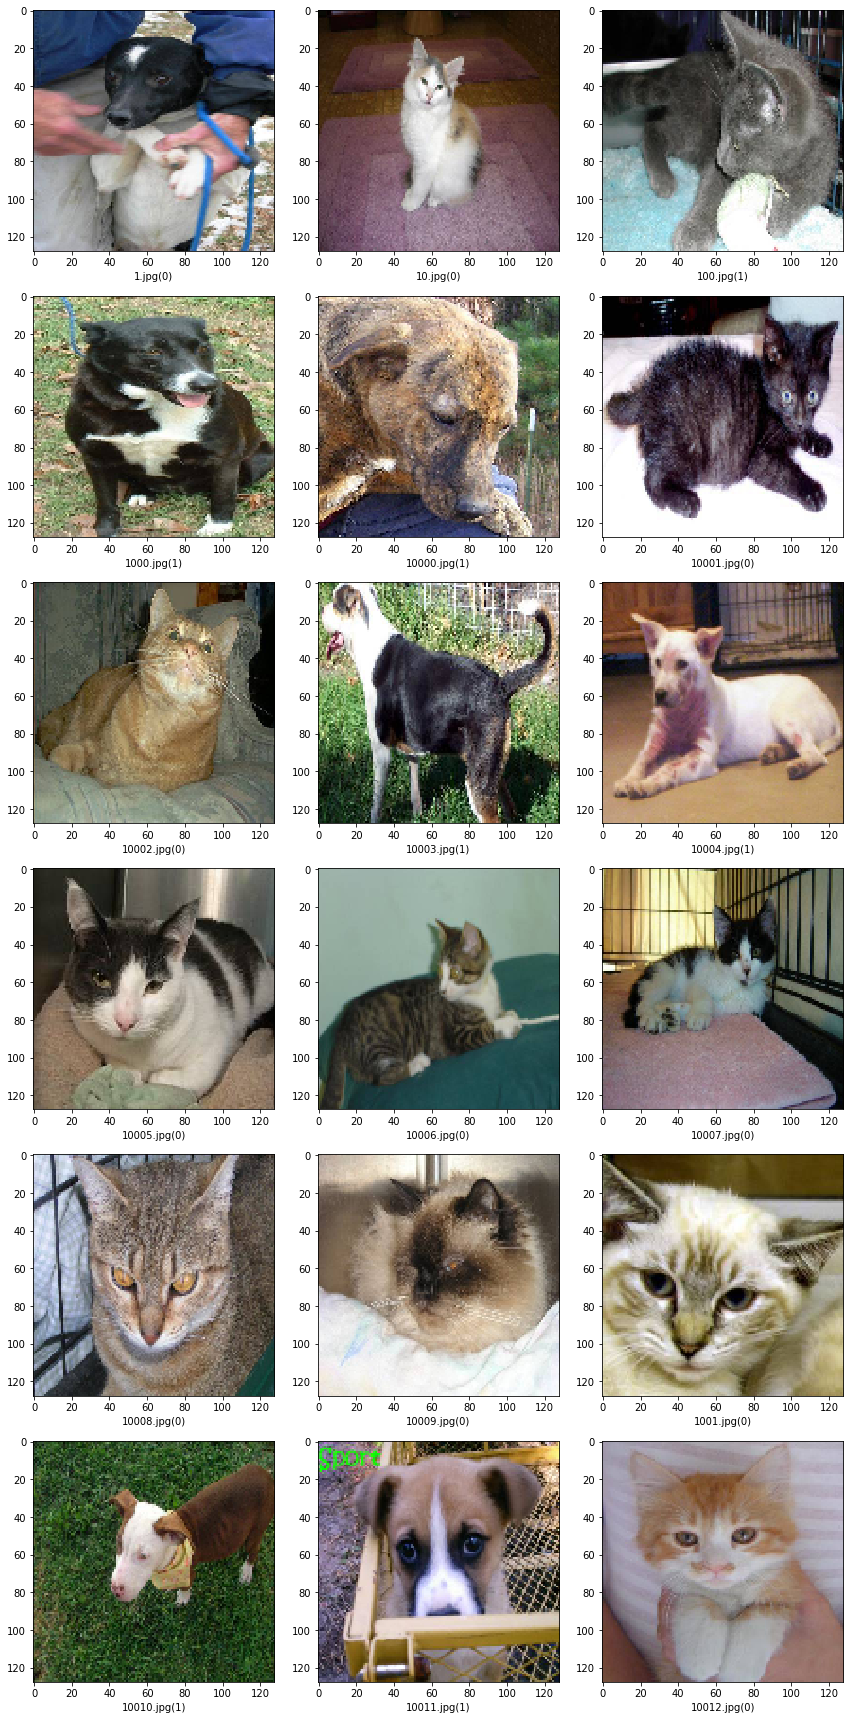

In [15]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../documents/input/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [16]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("../documents/input/test1/3.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1 dog


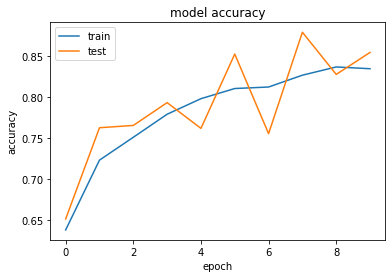

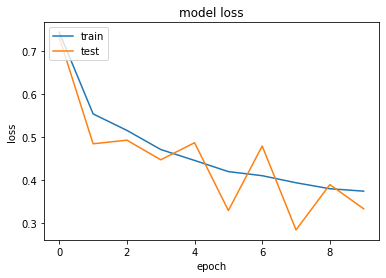

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.8345759510993958
validation_accuracy 0.8544544577598572


In [19]:
label = validation_generator.classes

In [20]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[1 1 0 ... 1 1 1]
{'cat': 0, 'dog': 1}
['dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', '

In [21]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices,label)
cf

array([[1167, 1169],
       [1348, 1316]], dtype=int64)

In [22]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,1,All
Actual,,,
0,1167,1348,2515
1,1169,1316,2485
All,2336,2664,5000


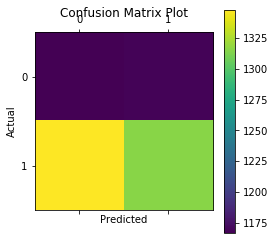

In [23]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();